# Vehicle Detection
----


## Import Packages

In [1]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
import random
import glob
import time
import pickle

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib

from scipy.stats import linregress
from skimage.feature import hog
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/home/falreis/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#import udacity lesson code (functions)
import udacity_features as uf
import udacity_window as uw
import udacity_plot3d as u3d

In [4]:
#import previous projects functions
import car_roi
import car_hough
import car_roi
import car_camera
import car_histogram
import car_warp

Region of Interests functions OK
Hough function OK
Camera calibration functions OK
Warp Pipeline OK


---

## Helper Functions

Below are some helper functions. Some of them are based on the first line lanes 
:)

In [5]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes

In [6]:
# Define a function that takes an image and a list of templates as inputs
# then searches the image and returns the a list of bounding boxes 
# for matched templates
def find_matches(img, template_list):
    draw_img = img.copy() # Make a copy of the image to draw on
    bbox_list = [] # Define an empty list to take bbox coords
    
    for it in template_list: # Iterate through template list
        tmp = mpimg.imread(it) # Read in templates one by one
        res = cv2.matchTemplate(draw_img, tmp, cv2.TM_CCOEFF_NORMED) # Use cv2.matchTemplate() to search the image
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
        w, h = (tmp.shape[1], tmp.shape[0])
        top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        bbox_list.append((top_left, bottom_right))

    # Use cv2.minMaxLoc() to extract the location of the best match
    # Determine bounding box corners for the match
    # Return the list of bounding boxes
    return bbox_list

In [27]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = uf.convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64 #*64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = uf.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = uf.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = uf.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = uf.bin_spatial(subimg, size=spatial_size)
            hist_features = uf.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img
    

In [8]:
def vehicle_detection_pipeline(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)
    return hog_image

print('Pipeline OK')

Pipeline OK


---

---

## Test Images

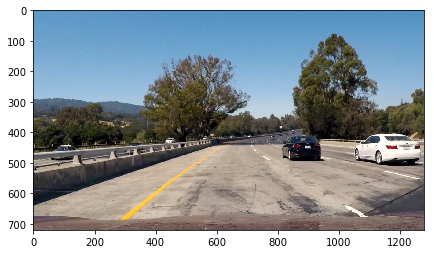

In [9]:
img_name = 'test_images/test1.jpg'
image = mpimg.imread(img_name)
plt.figure(figsize=(7,7))
plt.imshow(image)

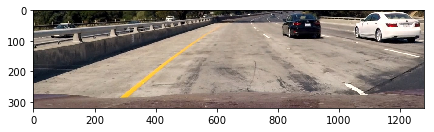

In [10]:
crop_img = image[400:,:]
plt.figure(figsize=(7,7))
plt.imshow(crop_img)

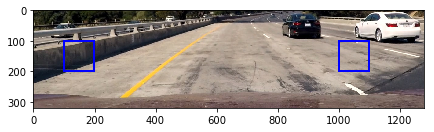

In [11]:
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((100, 100), (200, 200)), ((1000, 100), (1100, 200))]
result = draw_boxes(crop_img, bboxes)
plt.figure(figsize=(7,7))
plt.imshow(result)

/home/falreis/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


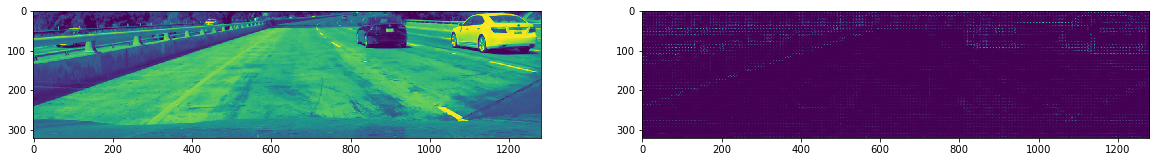

In [12]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

hls_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2HLS)[:,:,2]
luv_img = cv2.cvtColor(crop_img, cv2.COLOR_RGB2LUV)[:,:,1]

gray = cv2.cvtColor(crop_img, cv2.COLOR_RGB2GRAY)
features, hog_image = uf.get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(gray)
ax2.imshow(hog_image)

In [13]:
# Read in car and non-car images
images = glob.glob('dataset/combined/*.jpeg')
cars = []
notcars = []

for image in images:
    if 'image' in image or 'extra' in image or 'not' in image:
        notcars.append(image)
    else:
        cars.append(image)

print(len(cars), len(notcars))
        
#keep cars and not cars lists with the same size
len_cars = len(cars)
len_notcars = len(notcars)

if len_cars > len_notcars:
    for i in range(len_notcars, len_cars):
        rand = random.randint(0,len_notcars)
        image = notcars[rand]
        notcars.append(image)
elif len_cars < len_notcars:
    for i in range(len_cars, len_notcars):
        rand = random.randint(0,len_cars)
        image = cars[rand]
        cars.append(image)
    
print(len(cars), len(notcars))

1196 1125
1196 1196


In [14]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 8    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

In [16]:
car_features = uf.extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = uf.extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

/home/falreis/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Train set

In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

print('Train OK')

#save svc
joblib.dump(svc, 'svc.pkl') 

#0.9763 RGB
#0.9892 HLS
#0.9892 LUV
#0.9871 LAB
#0.9871 HSV
#0.9914 YUV - 0.9957 (8 HIST_BIN) - 0.9935 (16 HIST_BIN) - (1.0 9ori, 8hist)
#0.9871 YCrCb

In [ ]:
#print slide windows size index*64 (64-192)
'''
for i in range(1,4):
    windows = slide_window(crop_img, x_start_stop=[None, None], y_start_stop=[None, None]
                           , xy_window=(i*64, i*64), xy_overlap=(0.5, 0.5))
    window_img = draw_boxes(crop_img, windows, color=(0, 0, 255), thick=2)
    
    plt.figure(figsize=(20,10))
    plt.imshow(window_img)
'''

In [32]:
svc = joblib.load('svc.pkl') 
#dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )

img = crop_img.copy() #mpimg.imread('test_image.jpg')

ystart = 0 #400
ystop = 300 #656
scale = 1 #1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

/home/falreis/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


ValueError: operands could not be broadcast together with shapes (1,6084) (2556,) (1,6084) 

/home/falreis/miniconda2/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


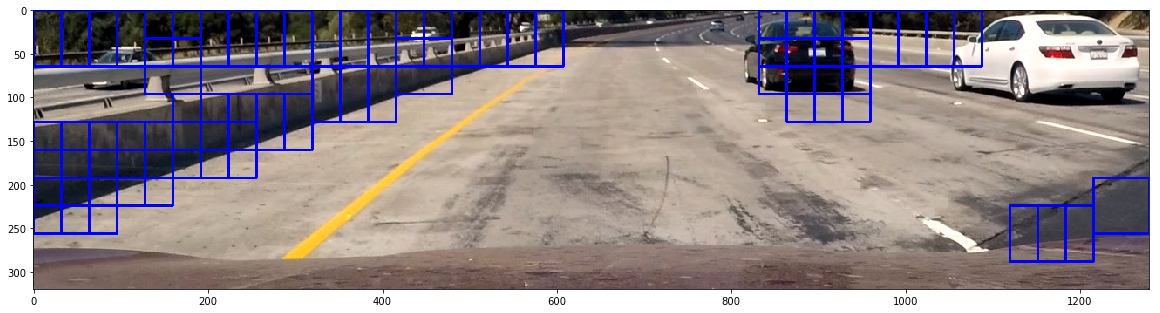

In [22]:
image = crop_img.copy() #mpimg.imread('examples/bbox-example-image.jpg')
#image = mpimg.imread('cutouts/cutout4.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = uw.slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

hot_windows = uw.search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=True, 
                        hist_feat=True, hog_feat=True)                       
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    

plt.figure(figsize=(20,10))
plt.imshow(window_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Provided videos: `project_video.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

Let's try the one with the solid white lane on the right first ...

In [ ]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

pp_hist = False
video_output = 'output_test_video.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(vehicle_detection_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Optional Challenge

Challenge the others videos.
`challenge_video.mp4`
`hard_challenge_video.mp4`